In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import SVI
from pyro.optim import Adam
from pyro.params import param_with_module_name
from pyro.util import ng_ones, ng_zeros

In [2]:
class GPRegressor(nn.Module):
    def __init__(self, X, y, kernel, name="GPR", priors={}, noise=torch.Tensor([0.01]),
                 jitter_level=1e-6):
        super(GPRegressor, self).__init__()
        self.X = X
        self.y = y
        self.N = self.X.size(0)
        self.kernel = kernel
        self.name = name
        self.kernel_name = self.name + ".kernel"
        self.priors = priors
        self.noise = Variable(noise)
        self.jitter_level = jitter_level
        pyro.clear_param_store()
        
    def model(self):
        kernel_fn = pyro.random_module(self.kernel_name, self.kernel, self.priors)
        kernel_module = kernel_fn()
        K = kernel_module.K(self.X) + Variable(torch.eye(self.N)) * self.jitter_level
        L = torch.potrf(K, upper=False)
        normal = pyro.sample(self.name + ".normal",
                             dist.Normal(ng_zeros(self.N), ng_ones(self.N)))
        f = L.matmul(normal)
        pyro.sample("y", dist.Normal(f, self.noise.repeat(self.N)), obs=self.y)
        
    def guide(self):
        guide_priors = {}
        for p in self.priors:
            p_MAP_name = param_with_module_name(self.kernel_name, p) + "_MAP"
            p_MAP = pyro.param(p_MAP_name,
                               Variable(self.priors[p].analytic_mean(), requires_grad=True))
            guide_priors[p] = dist.Delta(p_MAP)
        kernel_fn = pyro.random_module(self.kernel_name, self.kernel, guide_priors)
        kernel_module = kernel_fn()
        pyro.sample(self.name + ".normal", dist.Normal(ng_zeros(self.N), ng_ones(self.N)))
        return kernel_module
        
    def fit(self, lr=0.1, n_iter=1000):
        pyro.clear_param_store()
        optim = Adam({"lr": lr})
        svi = SVI(self.model, self.guide, optim, loss="ELBO", trace_graph=True)
        losses = []
        for i in range(n_iter):
            losses.append(svi.step())
        return losses
    
    def forward(self, Z):
        kernel_module = self.guide()
        K = kernel_module.K(self.X) + self.noise.repeat(self.N).diag()
        L = torch.potrf(K, upper=False)
        K_xz = kernel_module(self.X, Z)
        K_zx = K_xz.t()
        K_zz = kernel_module.K(Z)
        loc = K_zx.matmul(torch.potrs(self.y, L, upper=False)).squeeze(1)
        f_scale = K_zz - K_zx.matmul(torch.potrs(K_xz, L, upper=False))
        y_scale = f_scale + self.noise.repeat(Z.size(0)).diag()
        return loc, y_scale

In [3]:
class RBFKernel(nn.Module):
    def __init__(self, variance=torch.ones(1), lengthscale=torch.ones(1)):
        super(RBFKernel, self).__init__()
        self.variance_unconstrained = nn.Parameter(torch.log(variance.exp() - 1))
        self.lengthscale_unconstrained = nn.Parameter(torch.log(lengthscale.exp() - 1))
    
    def forward(self, x, z=None):
        if z is None:
            z = x
        lengthscale = F.softplus(self.lengthscale_unconstrained)
        x = x / lengthscale
        z = z / lengthscale
        xz = x.ger(z)
        xx = x.unsqueeze(1) ** 2
        zz = z.unsqueeze(0) ** 2
        k = F.softplus(self.variance_unconstrained) * torch.exp(-0.5 * (xx - 2*xz + zz))
        return k
    
    def K(self, X, Z=None):
        return self(X, Z)

In [4]:
def plot(model, n_sample=10):
    Z = Variable(torch.linspace(0, 5, 100), volatile=True)
    mean, cov = model(Z)
    sd = cov.diag().sqrt()
    plt.figure(figsize=(12, 6))
    plt.plot(model.X.data.numpy(), model.y.data.numpy(), 'kx', mew=2)
    plt.plot(Z.data.numpy(), mean.data.numpy(), 'C0', lw=2)
    plt.fill_between(Z.data.numpy(),
                     mean.data.numpy() - sd.data.numpy(),
                     mean.data.numpy() + sd.data.numpy(),
                     color='C0', alpha=0.2)
    if n_sample > 0:
        L = torch.potrf(cov, upper=False)
        normal = dist.Normal(ng_zeros(Z.size()), ng_ones(Z.size()))
        for _ in range(n_sample):
            u = mean + L.matmul(normal.sample())
            plt.plot(Z.data.numpy(), u.data.numpy(), 'C0', lw=2, alpha=0.1)
    plt.xlim(0, 5)
    plt.ylim(-2, 2)

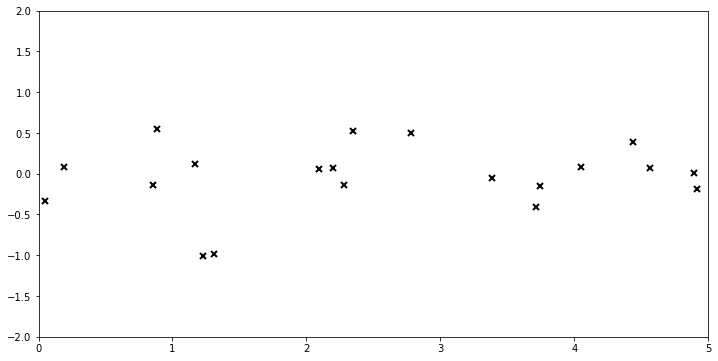

In [5]:
N = 20
X = dist.Uniform(ng_zeros(N), ng_ones(N)*5).sample()
y = 0.5 * torch.sin(3*X) + dist.Normal(ng_zeros(N), ng_ones(N)*0.5).sample()
plt.figure(figsize=(12, 6))
plt.plot(X.data.numpy(), y.data.numpy(), 'kx', mew=2)
plt.xlim(0, 5)
plt.ylim(-2, 2);

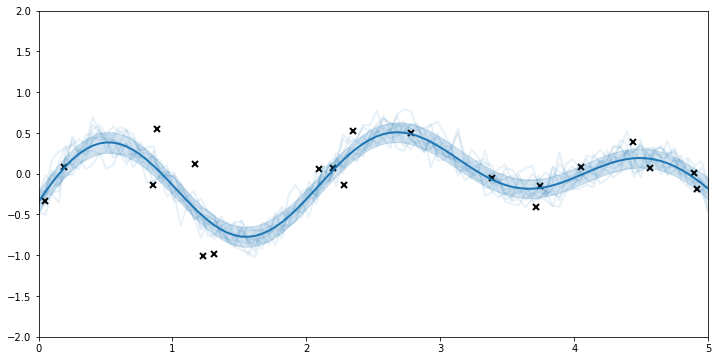

In [6]:
kernel = RBFKernel()
model = GPRegressor(X, y, kernel)
plot(model)

In [10]:
losses = model.fit(lr=0.1, n_iter=2000)
plt.plot(losses[500:])

RuntimeError: Lapack Error in potrf : the leading minor of order 20 is not positive definite at /opt/conda/conda-bld/pytorch_1512382878663/work/torch/lib/TH/generic/THTensorLapack.c:617

In [8]:
pyro.get_param_store().named_parameters()

dict_items([('GPR.kernel$$$lengthscale_unconstrained', Parameter containing:
 1.2024
[torch.FloatTensor of size 1]
), ('GPR.kernel$$$variance_unconstrained', Parameter containing:
-6.9118
[torch.FloatTensor of size 1]
)])

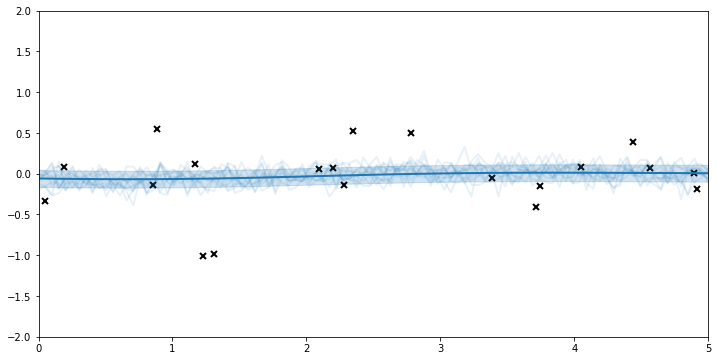

In [9]:
plot(model)